In [119]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
import pymc as pm
import seaborn as sns
from itertools import product
from collections import defaultdict


Parts of the code in this notebook is from {https://tanyaschlusser.github.io/posts/mcmc-and-the-ising-model/}. 

In [2]:
# Acceptance-Rejection Sampling
def gaussian(x, mean, sd):
    return (1 / (np.sqrt(2*np.pi) * sd)) * np.exp(-0.5 * ((x - mean) / sd)**2)

def uniform(x, start, end):
    return 1 / ( end - start )

def f(x): 
    return 0.5 * gaussian( x, 2, 1 ) + 0.5 * gaussian( x, -2, 1 )

# xx = np.linspace(-7, 7, 1000)
# plt.plot(xx, f(xx))

In [3]:
def accept_reject(f, p, start, end):

    xx = np.linspace(start, end, 1000)
    M = max(f(xx) / p(xx, start, end)) * 1.01
    samples = []
    accept_count = 0
    total_count = 0

    while len(samples) < 5000:

        total_count += 1
        
        Y = random.uniform( start, end )
        U = random.random()

        if U < f( Y )/ ( M * p( Y, start, end ) ):
            samples.append(Y)
            accept_count += 1

    ratio = accept_count / total_count

    return samples, ratio


def accept_reject_bruteforce(f, p, start, end):

    samples = []
    accept_count = 0
    total_count = 0

    while len(samples) < 5000:

        total_count += 1
        
        Y = random.uniform( start, end )
        U = random.random()

        if U < f(Y):
            samples.append(Y)
            accept_count += 1

    ratio = accept_count / total_count

    return samples, ratio


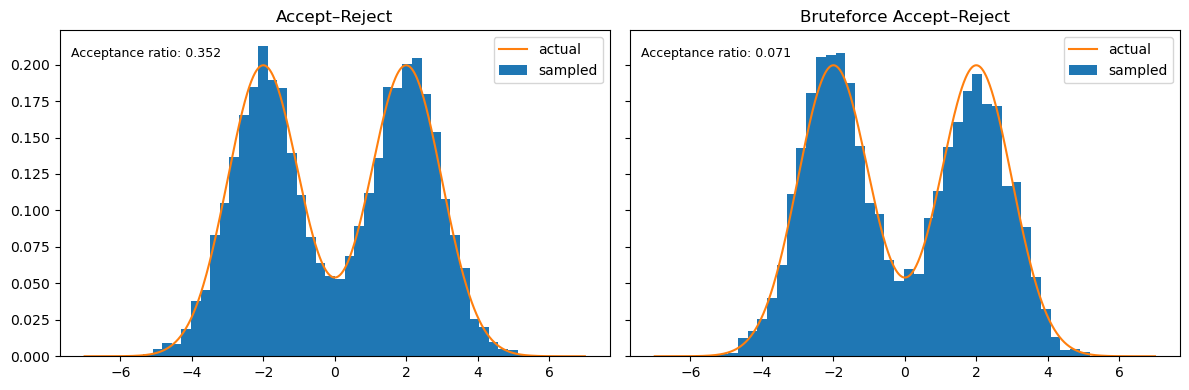

In [4]:
samples, ratio = accept_reject(f, uniform, -7, 7)
samples_1, ratio_1 = accept_reject_bruteforce(f, uniform, -7, 7)

xx = np.linspace(-7, 7, 1000)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ---- First plot ----
axes[0].hist(samples, bins=40, density=True)
axes[0].plot(xx, f(xx))
axes[0].set_title("Accept–Reject")
axes[0].legend(["actual", "sampled"])

axes[0].text(
    0.02, 0.95,
    f"Acceptance ratio: {ratio:.3f}",
    transform=axes[0].transAxes,
    fontsize=9,
    va="top",
)

# ---- Second plot ----
axes[1].hist(samples_1, bins=40, density=True)
axes[1].plot(xx, f(xx))
axes[1].set_title("Bruteforce Accept–Reject")
axes[1].legend(["actual", "sampled"])

axes[1].text(
    0.02, 0.95,
    f"Acceptance ratio: {ratio_1:.3f}",
    transform=axes[1].transAxes,
    fontsize=9,
    va="top",
)

plt.tight_layout()
plt.show()

In [5]:
# MCMC Example and Replica Exchange

def MH_sample(f, p, x0, N):

    x = x0
    sample = [x0]

    accept = 0
    
    for i in range(N):

        x = sample[-1]
        y = p(x)
        a = min(1, f(y)/f(x)) # symmetric proposal, reduces to metropolis
        U = random.random()
        if U <= a:
            sample.append(y)
            accept += 1
        else:
            sample.append(x)

    return sample[int(N *  1/10 ) : ], accept / N

def normal_proposal(x, sigma = 0.5):
    return x + np.random.normal(0, sigma)

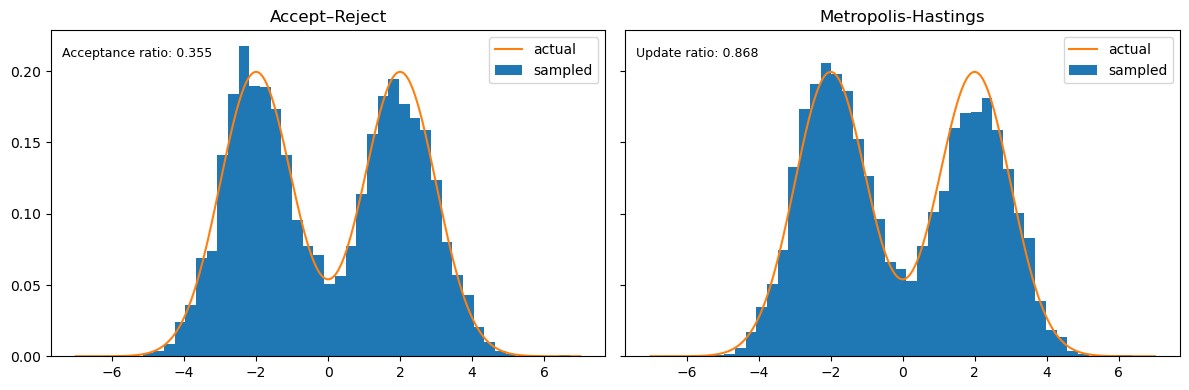

In [6]:
samples, ratio = accept_reject(f, uniform, -7, 7)
# samples_1, ratio_1 = simple_metropolis_hastings(lambda x: 5 * f(x), uniform, -7, 7, 10000) # not probability density

samples_1, ratio_1 = MH_sample(lambda x: 5 * f(x), normal_proposal, 0, 20000)

xx = np.linspace(-7, 7, 1000)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ---- First plot ----
axes[0].hist(samples, bins=40, density=True)
axes[0].plot(xx, f(xx))
axes[0].set_title("Accept–Reject")
axes[0].legend(["actual", "sampled"])

axes[0].text(
    0.02, 0.95,
    f"Acceptance ratio: {ratio:.3f}",
    transform=axes[0].transAxes,
    fontsize=9,
    va="top",
)

# ---- Second plot ----
axes[1].hist(samples_1, bins=40, density=True)
axes[1].plot(xx, f(xx))
axes[1].set_title("Metropolis-Hastings")
axes[1].legend(["actual", "sampled"])

axes[1].text(
    0.02, 0.95,
    f"Update ratio: {ratio_1:.3f}",
    transform=axes[1].transAxes,
    fontsize=9,
    va="top",
)

plt.tight_layout()
plt.show()

In [7]:
# Double Well, Replica Exchange:

def potential(x, a, b, T):

    k_B = 1
    # T = [0.5, 1, 2, 5]

    beta = 1 / ( k_B * T )
    return np.exp(-beta * a * ( x**2 - b**2 ) ** 2 )

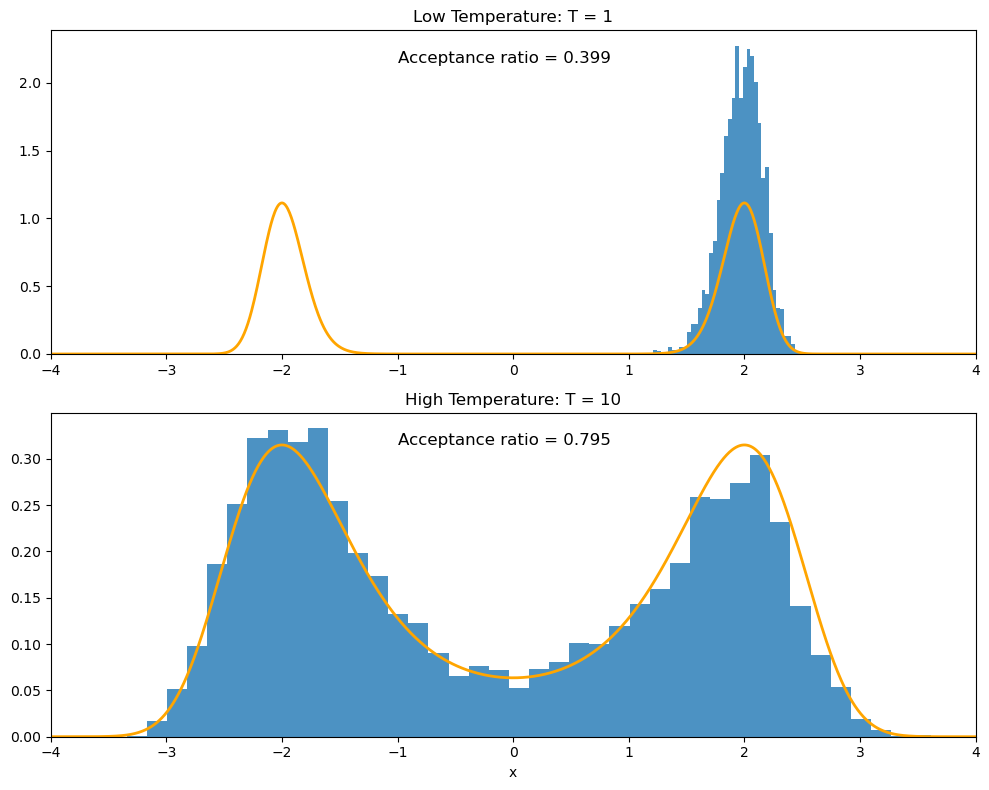

Acceptance ratio at T=1: 0.399
Acceptance ratio at T=10: 0.795


In [8]:
# Parameters
a, b = 1, 2
T_low = 1   # Low temperature (high beta)
T_high = 10  # High temperature (low beta)
N = 10000

# Sample at both temperatures
samples_low, ratio_low = MH_sample(lambda x: potential(x, a, b, T_low), 
                                    normal_proposal, 0, N)
samples_high, ratio_high = MH_sample(lambda x: potential(x, a, b, T_high), 
                                      normal_proposal, 0, N)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for low temperature
x_range = np.linspace(-4, 4, 1000)
target_low = potential(x_range, a, b, T_low)
target_low = target_low / np.trapezoid(target_low, x_range)  # Normalize

ax1.hist(samples_low, bins=40, density=True, alpha=0.8) 
         # edgecolor='black', linewidth=0.5, color='steelblue')
ax1.plot(x_range, target_low, 'orange', linewidth=2)
ax1.set_xlim(-4, 4)
# ax1.set_ylabel('Density')
ax1.set_title(f'Low Temperature: T = {T_low}')
ax1.text(-1, ax1.get_ylim()[1]*0.9, f'Acceptance ratio = {ratio_low:.3f}', fontsize=12)

# Plot for high temperature
target_high = potential(x_range, a, b, T_high)
target_high = target_high / np.trapezoid(target_high, x_range)  # Normalize

ax2.hist(samples_high, bins=40, density=True, alpha=0.8)
         # edgecolor='black', linewidth=0.5, color='steelblue')
ax2.plot(x_range, target_high, 'orange', linewidth=2)
ax2.set_xlim(-4, 4)
ax2.set_xlabel('x')
# ax2.set_ylabel('Density')
ax2.set_title(f'High Temperature: T = {T_high}')
ax2.text(-1, ax2.get_ylim()[1]*0.9, f'Acceptance ratio = {ratio_high:.3f}', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Acceptance ratio at T={T_low}: {ratio_low:.3f}")
print(f"Acceptance ratio at T={T_high}: {ratio_high:.3f}")

In [9]:
def Replica_Exchange(f, p, x0, T_chain, N, interval):

    # Here p takes in temperature T and returns a function 
    # T_chain orders temperature in in increasing order
    x = x0
    swaps = 0
    proposed_swaps = 0
    # accept = 0

    replicas = [[x] for i in range(len(T_chain))]
    num_replicas = len(replicas)
    
    for i in range(N):
        
        for j in range(num_replicas):

            previous = replicas[j][-1]
            # candidate = ( p(T_chain[j])( previous ) )
            candidate = p( previous ) 
            
            a = min(1, (f( T_chain[j] ))(candidate)/ (f( T_chain[j] ))(previous)) # symmetric proposal, reduces to metropolis
        
            U = random.random()
            if U <= a:
                replicas[j].append(candidate)
                # accept += 1
            else:
                replicas[j].append(previous)
                
        if i % interval == 0:
            
            for k in range(num_replicas - 1):
                
                pswap = min( 1, math.exp( ( 1/T_chain[k] - 1/T_chain[k+1] ) 
                                          * ( (f( T_chain[k] ))( replicas[k][-1] ) - (f( T_chain[k+1] )) ( replicas[k+1][-1] ) ) ) )
                U = random.random()
                swaps += 1 
                
                if U <= pswap:
                    proposed_swaps += 1
                    replicas[k][-1], replicas[k+1][-1] = replicas[k+1][-1], replicas[k][-1]
                    break

    for i in range(num_replicas):

        replicas[i] = replicas[i][int( 1/10 * N): ]

    return replicas, proposed_swaps / swaps

def f_example(T):
    
    return lambda x: potential(x, 1, 2, T)

In [10]:
T_chain = [0.1, 1, 10]
N = 200000
interval = 200
samples, swaps = Replica_Exchange( f_example, normal_proposal, 0, T_chain, N, interval )

Swap rate: 0.7256637168141593
Number of samples per replica: [180001, 180001, 180001]


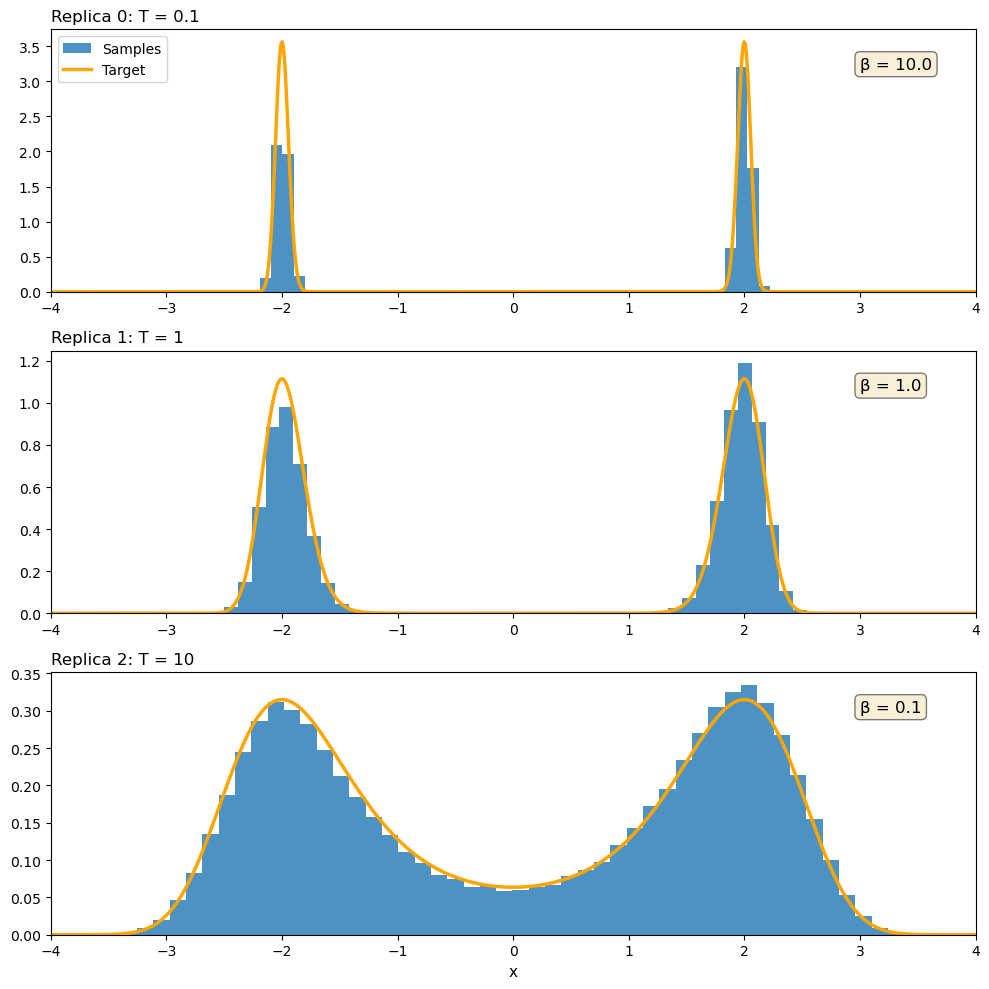

In [11]:
print(f"Swap rate: {swaps }")
# print(f"Number of samples per replica: {[len(s) for s in samples]}")

# Create subplots - one for each temperature
fig, axes = plt.subplots(len(T_chain), 1, figsize=(10, 10))

# Parameters for plotting
a, b = 1, 2
x_range = np.linspace(-4, 4, 1000)

# Plot each replica
for idx, (ax, T) in enumerate(zip(axes, T_chain)):
    # Get samples for this replica
    replica_samples = samples[idx]
    
    # Calculate target distribution at this temperature
    target = potential(x_range, a, b, T)
    target = target / np.trapezoid(target, x_range)  # Normalize
    
    # Plot histogram of samples
    ax.hist(replica_samples, bins=50, density=True, alpha=0.8, label='Samples')
            # edgecolor='black', linewidth=0.5, color='steelblue', label='Samples')
    
    # Plot target distribution
    ax.plot(x_range, target, 'orange', linewidth=2.5, label='Target')
    
    # Formatting
    ax.set_xlim(-4, 4)
    # ax.set_ylabel('Density', fontsize=11)
    beta = 1/T
    ax.text(3, ax.get_ylim()[1]*0.85, f'β = {beta:.1f}', fontsize=12, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.set_title(f'Replica {idx}: T = {T}', fontsize=12, loc='left')
    
    if idx == 0:
        ax.legend(loc='upper left')
    
    if idx == len(T_chain) - 1:
        ax.set_xlabel('x', fontsize=11)

plt.tight_layout()
plt.savefig('replica_exchange_results.png', dpi=150, bbox_inches='tight')
plt.show()

# # Print acceptance statistics
# print("\nSample statistics:")
# for idx, T in enumerate(T_chain):
#     mean_x = np.mean(samples[idx])
#     std_x = np.std(samples[idx])
#     print(f"T = {T}: mean = {mean_x:.3f}, std = {std_x:.3f}")

### Here we let J = 1, beta = 1/T,  and h = 0 for simplicity

Runtime: 0.314573 seconds


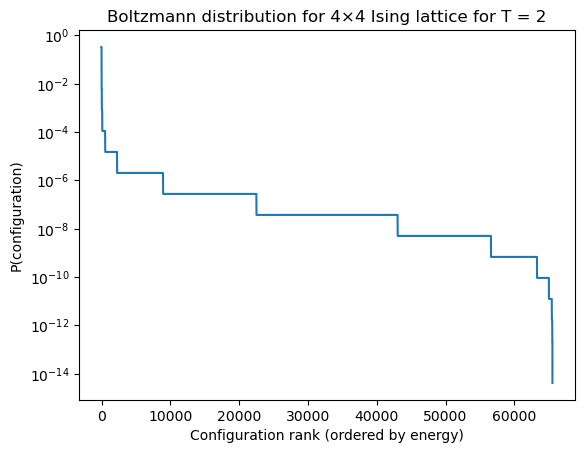

In [177]:
L = 4
N = L*L
J = 1.0
h = 0.0
T = 2
beta = 1/T

start = time.perf_counter()

# ----------------------------
# neighbors
# ----------------------------
def neighbors(i):
    r, c = divmod(i, L)
    return [((r+1)%L)*L+c,
            ((r-1)%L)*L+c,
            r*L+(c+1)%L,
            r*L+(c-1)%L]

nbrs = [neighbors(i) for i in range(N)]

# ----------------------------
# energy function
# ----------------------------
def energy(cfg):
    E = 0
    for i in range(N):
        for j in nbrs[i]:
            if j > i:                       # avoid double counting
                E -= J * cfg[i] * cfg[j]
    E -= h * sum(cfg)
    return E

# ----------------------------
# enumerate all configurations
# ----------------------------
energies = []
for cfg in product([-1,1], repeat=N):
    energies.append(energy(cfg))

energies = np.array(energies)

# ----------------------------
# sort by energy
# ----------------------------
order = np.argsort(energies)
E_sorted = energies[order]

# ----------------------------
# Boltzmann probabilities
# ----------------------------
weights = np.exp(-beta * E_sorted)
P = weights / weights.sum()

x = np.arange(len(P)) + 1

end = time.perf_counter()
print(f"Runtime: {end - start:.6f} seconds")

# ----------------------------
# plot
# ----------------------------
plt.figure()
plt.plot(x, P)
plt.xlabel("Configuration rank (ordered by energy)")
plt.ylabel("P(configuration)")
plt.title(f"Boltzmann distribution for {L}×{L} Ising lattice" + f" for T = {T}")
plt.yscale("log")     # VERY helpful visualization choice
plt.show()

### We want to sample from this distribution, where low evergy states are much more likely, and the probability of higher energy states decrease in steps, as we can see from the graph

In [218]:
# Ising Model Example:


def random_model(n):
    return np.random.choice([-1, 1], size=(n, n))

def get_H(lattice):
    sum = 0
    rows, columns = lattice.shape
    for i in range(rows):
        for j in range(columns):
            for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                ii = (i + di) % rows
                jj = (j + dj) % columns
                sum -= lattice[ii, jj] * lattice[i, j]
    return sum
    

# def Ising_proposal(lattice, biased = 0.05):
    
#     n = len(lattice)
#     new = lattice.copy()    

#     for i in range(n):
#         for j in range(n):

#             U = random.random()
                
#             if U <= biased:
#                 new[i][j] = -new[i][j]

#     return new

# def manual_MCMC(T, lattice, N = 100000):
    
#     rows, columns = lattice.shape
#     previous = lattice
    
#     energy = []
    
#     for i in range(N):

#         proposed = Ising_proposal(previous)
        
#         a = min(1, math.exp( - ( get_H( proposed ) - get_H( previous ) )  / T ) )
        
#         U = random.random()
#         if U <= a:
#             energy.append( get_H( proposed ) )
#             previous = proposed
#         else: 
#             energy.append( get_H( previous ) )

#     return energy[int(1/10 * N): ]

def mag(lattice):
    # print('magnetization: {:3.0%}'
    #           .format(abs(lattice.sum()) / lattice.size))
    return abs(lattice.sum()) / lattice.size


def get_DH(lattice, location):
    i, j = location
    height, width = lattice.shape
    H, Hflip = 0, 0
    for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        ii = (i + di) % height
        jj = (j + dj) % width
        H -= lattice[ii, jj] * lattice[i, j]
        Hflip += lattice[ii, jj] * lattice[i, j]
    return Hflip - H
            
def manual_MCMC(T, lattice, N = 200000):
    rows, columns = lattice.shape
    energy = []
    mags = []
    
    
    for i in range(N):
        for step in range(5):
            for i in range(rows):
                for j in range(columns):
                    
                    dH = get_DH(lattice, (i, j))

                    if dH < 0:
                        lattice[i, j] = -lattice[i, j]
                    else:
                        prob = np.exp(-dH / T)
                        
                        if np.random.rand() < prob:
                            lattice[i, j] = -lattice[i, j]
               
        energy.append(get_H(lattice))
        mags.append(mag(lattice))
        

    return energy[int(1/10 * N): ], mags[int(1/10 * N): ]
    

In [205]:
start = time.perf_counter()
model = random_model(10)
energy, mag = manual_MCMC(2, model)
end = time.perf_counter()

Runtime: 309.949319 seconds


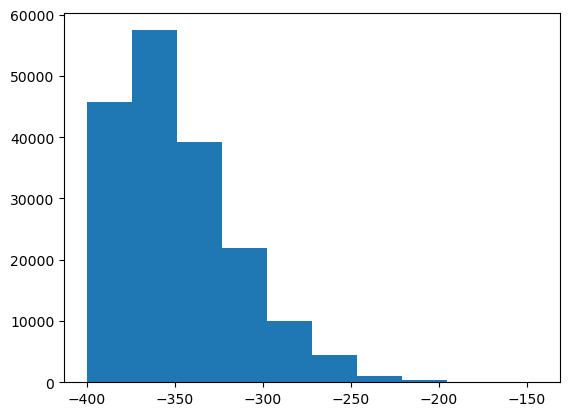

In [208]:
plt.hist(energy, bins = 10)
print(f"Runtime: {end - start:.6f} seconds")

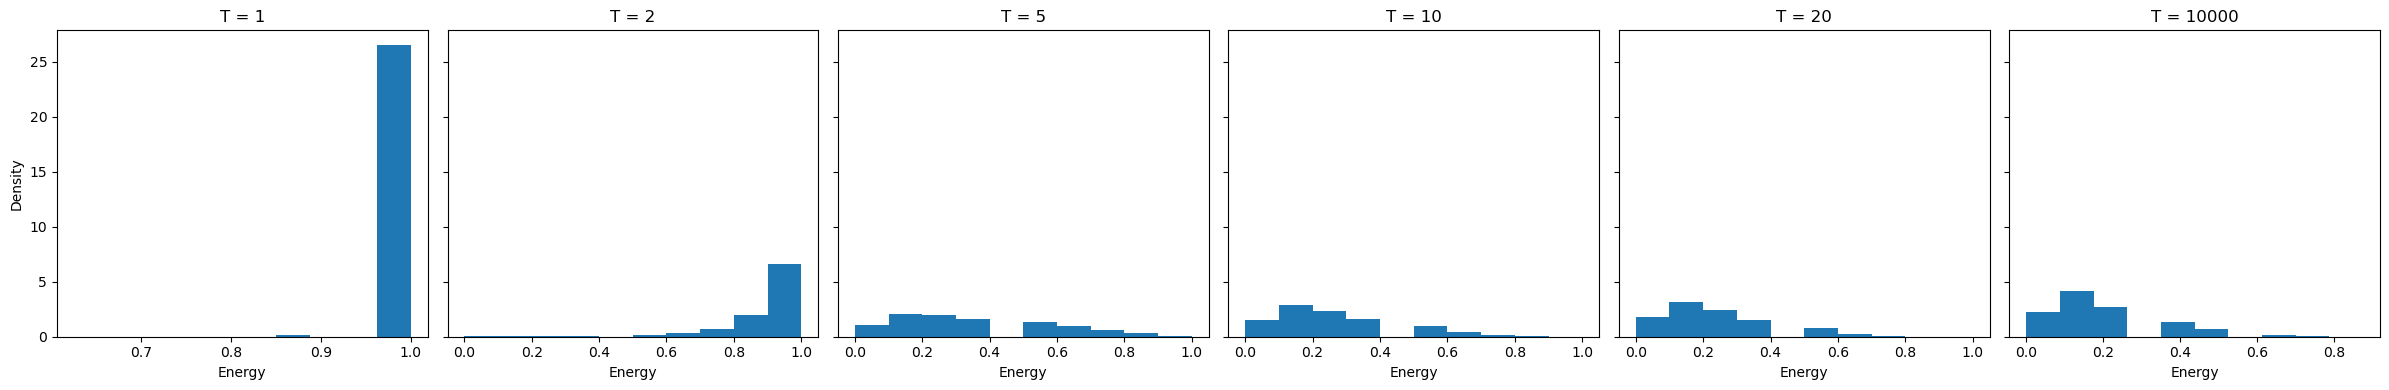

In [221]:
temperatures = [1, 2, 5, 10, 20, 10000]

# Create a random initial model
model = random_model(4)

# Set up subplots: one row, len(temperatures) columns
fig, axes = plt.subplots(1, len(temperatures), figsize=(4*len(temperatures), 4), sharey=True)

for i, T in enumerate(temperatures):
    # Run your MCMC
    energy, mags = manual_MCMC(T, model, 100000)
    
    # Plot histogram
    axes[i].hist(mags, density=True, bins=10)
    axes[i].set_xlabel("Energy")
    axes[i].set_ylabel("Density" if i == 0 else "")
    axes[i].set_title(f"T = {T}")

plt.tight_layout()
plt.show()